## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne


# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [ ]:
def print_graphs(data):
    for i in range(0, 84, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 84, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 84, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [ ]:
data = np.load("../dataset/sc/DataSet_A_2/single/data_unificada.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
data = data.swapaxes(2, 1)
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
data.shape

Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

In [ ]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [ ]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../dataset/sc/DataSet_A_2/single/label_unificada.npy")
labels = labels.swapaxes(1, 0)
labels = labels.reshape(labels.shape[1] * labels.shape[2])
print(labels, labels.shape)
np.save("../dataset/sc/DataSet_A_2/single/labels_formated.npy", labels)

In [ ]:
# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data.reshape(data.shape[0], 1, data.shape[1])
# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(labels.shape[0], dtype=int),
    le.fit_transform(labels))
)
event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5, '10':6}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()


# Filtrando e salvando os dados pelo objeto MNE

In [ ]:
# aplicando o filtro
mne_data_filtered = mne_data.filter(l_freq=4., h_freq=12)

# salvando os dados
mne_data_filtered.save(fname="../dataset/sc/DataSet_A_2/single/mne_data.fif", overwrite=True)

# Criação do MNE para o multi target

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [ ]:
def print_graphs(data):
    for i in range(0, 100, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 100, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 100, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

In [ ]:
data = np.load("../dataset/sc/DataSet_A_2/multi/data_unificada.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
#data = data.swapaxes(2, 1)
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
data.shape

Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

In [ ]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [ ]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../dataset/sc/DataSet_A_2/multi/label_unificada.npy")
#labels = labels.swapaxes(1, 0)
labels = labels.reshape(labels.shape[0] * labels.shape[1])
print(labels, labels.shape)
np.save("../dataset/sc/DataSet_A_2/multi/labels_formated.npy", labels)

In [ ]:
# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data.reshape(data.shape[0], 1, data.shape[1])
print(data_correct.shape)
# adicionando label como "épocas" do sinal

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(100, dtype=int),
    le.fit_transform(labels))
)
event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()

# Filtrando e salvandos os dados pelo objeto MNE

In [ ]:
# aplicando o filtro
mne_data_filtered = mne_data.filter(l_freq=4., h_freq=12)

# salvando os dados
mne_data_filtered.save(fname="../dataset/sc/DataSet_A_2/multi/mne_data.fif", overwrite=True)

### Tarefas

- Estudar e utilizar os exemplos já apresentados no repositório `tutoriais` e criar o objeto `mne.EpochArray` para os dados *single* e *multi-target* (`AVI dataset`);
- Estudar documentos MNE para realizar a aplicação dos filtros temporais a partir de objetos `mne.EpochArray` (sempre verificando as frequências utilizadas como targets dos `datasets`). Isto também para os dados *single* e *multi-target* (`AVI dataset`);
- **Ótimo**: elaborar toda a aplicação já realizada até o ponto anterior para o *dataset* `Beta`.

# Criação do mne para o beta

In [ ]:
def print_graphs(data):
    for i in range(0, 10, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 10, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 10, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

In [40]:
from scipy.io import loadmat
data = loadmat("../dataset/beta/S12.mat")['data'][0][0]

eeg_data = data[0]

print(eeg_data.shape)

(64, 750, 4, 40)


In [33]:
eeg = eeg_data.reshape(eeg_data.shape[0], eeg_data.shape[1], eeg_data.shape[2] * eeg_data.shape[3])
labels = np.array(list(data[1]['freqs'][0][0].flatten()) * 4)
print(eeg.shape, labels.shape)

(64, 750, 160) (160,)


In [34]:
# criação de um objeto "info"
n_channels = 64
sfreq = data[1]['srate'][0][0][0][0]
ch_names = [data[1]['chan'][0][0][index][3][0] for index in range(64)]
ch_types = ['eeg'] * 64
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
>

In [39]:
# data : array, shape (n_epochs, n_channels, n_times)
# (64, 750, 160) -> (160, 64, 750)
data_correct = eeg.swapaxes(0, 2)
data_correct = data_correct.swapaxes(1, 2)
print(data_correct.shape)

# adicionando label como "épocas" do sinal
# labels = np.load("../datasets/avi/single/labels.npy")[0]
# # print(labels, labels.shape)

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(len(labels), dtype=int),
    le.fit_transform(labels))
)
# print(events)

event_dict = {'8':0, '8.2':1, '8.4':2, '8.6':3, '8.8':4, '9':5,
              '9.2':6, '9.4':7, '9.6':8, '9.8':9, '10':10, '10.2':11,
              '10.4':12, '10.6':13, '10.8':14, '11':15, '11.2':16, '11.4':17,
              '11.6':18, '11.8':19, '12':20, '12.2':21, '12.4':22, '12.6':23,
              '12.8':24, '13':25, '13.2':26, '13.4':27, '13.6':28, '13.8':29,
              '14':30, '14.2':31, '14.4':32, '14.6':33, '14.8':34, '15':35,
              '15.2':36, '15.4':37, '15.6':38, '15.8':39}

mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
# print(mne_data)

(160, 64, 750)
Not setting metadata
160 matching events found


No baseline correction applied
0 projection items activated


PSD do evento com label 9.8


C:\Users\gregu\AppData\Local\Temp\ipykernel_8316\1450344703.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  view.plot(show=False)


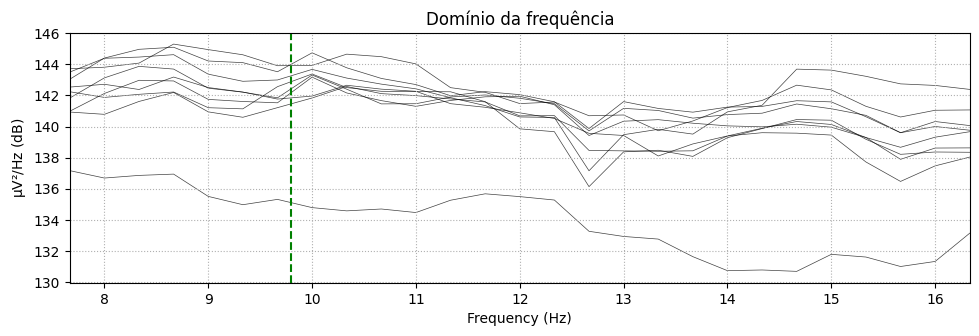

PSD do evento com label 10.6


C:\Users\gregu\AppData\Local\Temp\ipykernel_8316\1450344703.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  view.plot(show=False)


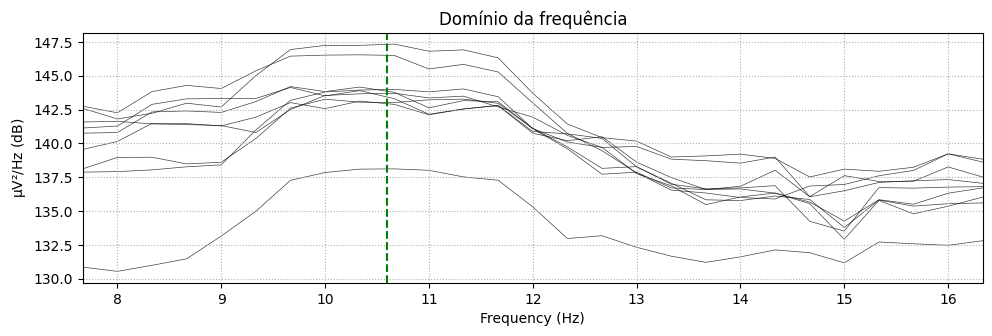

PSD do evento com label 12.600000000000001


C:\Users\gregu\AppData\Local\Temp\ipykernel_8316\1450344703.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  view.plot(show=False)


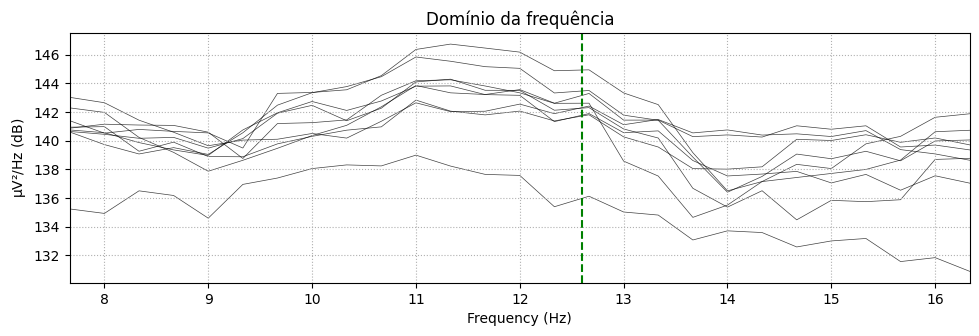

PSD do evento com label 15.600000000000001


C:\Users\gregu\AppData\Local\Temp\ipykernel_8316\1450344703.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  view.plot(show=False)


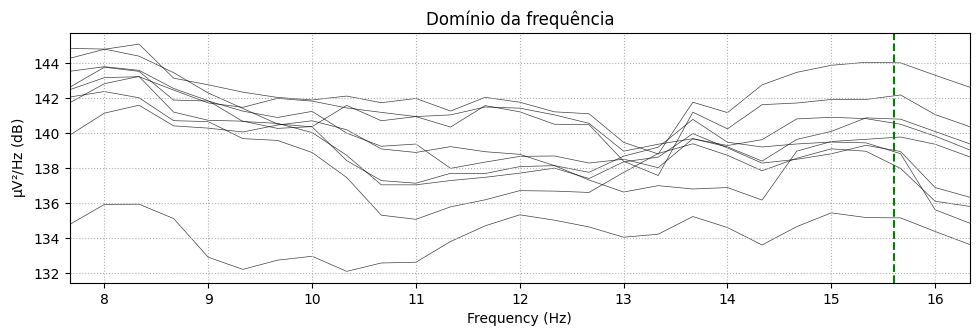

PSD do evento com label 12.600000000000001


C:\Users\gregu\AppData\Local\Temp\ipykernel_8316\1450344703.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  view.plot(show=False)


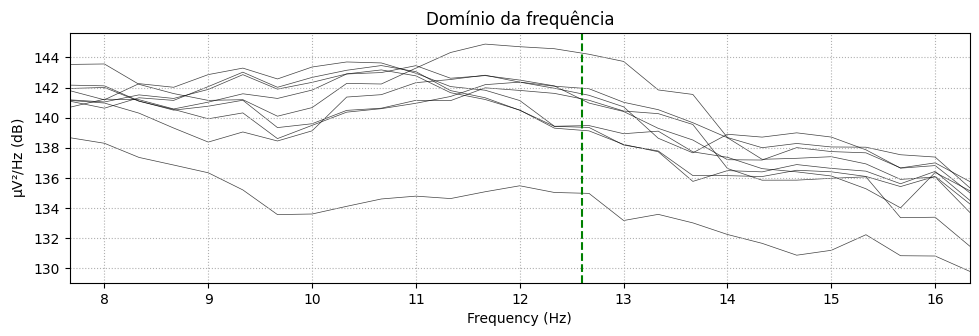

In [36]:
# import warnings
# warnings.filterwarnings('ignore')

mne_data_plot = mne_data
mne_data_plot = mne_data_plot.drop_channels([name for name in ch_names if name not in ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2']]) #['O1', 'OZ', 'O2']]) #

for i in [6, 10, 20, 35, 100]: #range(len(mne_data)):
    print('PSD do evento com label', labels[i])
    view = mne_data_plot[i].compute_psd(method='multitaper', fmin=7.5, fmax=16.5, verbose=False)
    view.plot(show=False)
    # print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data_plot[i].event_id)[0]), linestyle='--', color='green')
    plt.show()
# list(mne_data[0].event_id)

In [37]:
threshold = 0.5
freqs = data[1]['freqs'][0][0].flatten()

y_pred = []

#para todas as instancias
for i in range(len(mne_data)):
    #psd
    item = mne_data[i].compute_psd(method='multitaper', fmin=7.5, fmax=16.5, verbose=False)
    
    #pegar media de cada faixa de frequencia
    classes = []
    for freq in freqs:        
        classes.append( item.get_data(fmin=freq-threshold, fmax=freq+threshold).mean() )
    
    #verificar qual é a maior faixa de freq
    y_pred.append( freqs[np.argmax(classes)] )
    
#calcular acuracia
acuracia = sum(y_pred == labels) / len(labels)
print('Acurácia:',acuracia)

Acurácia: 0.05625


In [38]:
# Prova Real
accy = 0
for i in range(len(labels)):
    print(labels[i], y_pred[i])
    
    if labels[i] == y_pred[i]:
        accy += 1/len(labels)

print(accy)

8.6 8.0
8.799999999999999 8.2
9.0 15.0
9.2 8.6
9.4 8.6
9.6 8.6
9.8 8.2
10.0 8.0
10.2 10.0
10.4 8.0
10.6 10.2
10.8 11.2
11.0 10.0
11.2 8.0
11.4 8.0
11.6 12.600000000000001
11.8 8.0
12.0 8.0
12.2 11.2
12.4 8.0
12.600000000000001 11.2
12.8 9.2
13.0 8.0
13.200000000000001 8.2
13.4 8.0
13.600000000000001 8.0
13.8 8.0
14.0 10.2
14.200000000000001 8.0
14.4 8.2
14.600000000000001 8.0
14.8 12.0
15.0 10.6
15.200000000000001 8.0
15.4 8.0
15.600000000000001 8.0
15.8 8.0
8.0 10.6
8.2 8.0
8.4 8.0
8.6 8.6
8.799999999999999 8.0
9.0 9.0
9.2 9.2
9.4 8.2
9.6 10.2
9.8 8.2
10.0 10.6
10.2 10.2
10.4 9.6
10.6 8.0
10.8 10.0
11.0 8.6
11.2 11.0
11.4 10.2
11.6 12.0
11.8 11.6
12.0 8.2
12.2 8.0
12.4 10.0
12.600000000000001 8.0
12.8 11.6
13.0 8.0
13.200000000000001 15.0
13.4 13.200000000000001
13.600000000000001 11.6
13.8 8.0
14.0 13.0
14.200000000000001 8.0
14.4 8.0
14.600000000000001 8.0
14.8 8.0
15.0 8.0
15.200000000000001 8.6
15.4 9.2
15.600000000000001 11.6
15.8 8.0
8.0 8.6
8.2 8.0
8.4 8.0
8.6 9.2
8.79999999999

In [ ]:
data_correct = data.reshape(data.shape[0], 1, data.shape[2])
print(data_correct.shape)

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(40, dtype=int),
    le.fit_transform(labels))
)
event_dict = {'8':0, '8.2':1, '8.4':2, '8.6':3, '8.8':4, '9':5,
              '9.2':6, '9.4':7, '9.6':8, '9.8':9, '10':10, '10.2':11,
              '10.4':12, '10.6':13, '10.8':14, '11':15, '11.2':16, '11.4':17,
              '11.6':18, '11.8':19, '12':20, '12.2':21, '12.4':22, '12.6':23,
              '12.8':24, '13':25, '13.2':26, '13.4':27, '13.6':28, '13.8':29,
              '14':30, '14.2':31, '14.4':32, '14.6':33, '14.8':34, '15':35,
              '15.2':36, '15.4':37, '15.6':38, '15.8':39}
mne_data = mne.EpochsArray(data, info, events, event_id=event_dict)
mne_data